*Data source:*

- [*FAOSTAT: Food and Agriculture Organization of the United Nations*](https://www.fao.org/faostat/en/#release_calendar)
- [*The world bank*](https://databank.worldbank.org/)
- *https://www.worldeconomics.com/*

---
## 1. <a id='toc1_'></a>[Import libraries and other useful code](#toc1_)

In [1]:
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# define color palette
color_palette = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

## 2. <a id='toc1_'></a>[Read datasets & preprocessing](#toc2_)

### 2.1. <a id='toc2_1_'></a>[Crop dataset](#toc2_1_)

In [3]:
crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1', low_memory=False) # low_memory = False to avoid Dtypewarning

In [4]:
crop.shape

(4127584, 14)

In [5]:
# To have the same years in the datasets, filter the datasets from year 1990
crop = crop[crop['Year']>=1990]

In [6]:
crop.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
29,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1990,1990,ha,6037.0,E,NaN
30,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1991,1991,ha,5500.0,A,NaN
31,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1992,1992,ha,5500.0,A,NaN
32,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1993,1993,ha,5500.0,A,NaN
33,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1994,1994,ha,5500.0,A,NaN


In [7]:
# Delete innecessary columns
crop.drop(columns=['Area Code', 'Area Code (M49)','Item Code (CPC)','Element Code','Unit','Year Code','Flag','Note'], inplace=True)

In [8]:
crop['Element'].unique()

array(['Area harvested', 'Yield', 'Production', 'Stocks',
       'Producing Animals/Slaughtered', 'Laying', 'Yield/Carcass Weight',
       'Milk Animals', 'Prod Popultn'], dtype=object)

In [9]:
# delete element types
delete_elements = ['Stocks', 'Laying', 'Milk Animals', 'Prod Popultn', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight']

# Filter the DataFrame to exclude the rows with the specified elements, and keep area harvested, yield and production
crop = crop[~crop['Element'].isin(delete_elements)]

In [10]:
# Change the name to Elements type
crop['Element'] = crop['Element'].replace('Area harvested', 'area_harvested_ha')
crop['Element'] = crop['Element'].replace('Yield', 'yield_hg/ha')
crop['Element'] = crop['Element'].replace('Production', 'production_tonnes')

In [11]:
crop

,Area,Item Code,Item,Element,Year,Value
29,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1990,6037.00
30,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1991,5500.00
31,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1992,5500.00
32,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1993,5500.00
33,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1994,5500.00
...,...,...,...,...,...,...
4127579,Net Food Importing Developing Countries,1735,Vegetables Primary,production_tonnes,2018,87329042.25
4127580,Net Food Importing Developing Countries,1735,Vegetables Primary,production_tonnes,2019,89228014.79
4127581,Net Food Importing Developing Countries,1735,Vegetables Primary,production_tonnes,2020,90776061.71
4127582,Net Food Importing Developing Countries,1735,Vegetables Primary,production_tonnes,2021,94095378.28


In [12]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, Item and Year.

crop = crop.pivot_table(index=['Area', 'Item Code', 'Item', 'Year'], columns='Element', values='Value').reset_index()
# index: The columns we want to keep unchanged in the resulting DataFrame.
# columns: The column whose values will be used to create the new columns in the resulting DataFrame.
# values: The column whose values will be used to populate the resulting DataFrame. 

Element,Area,Item Code,Item,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.0,1650000.0,10510.0
1,Afghanistan,15,Wheat,1991,1690000.0,1726000.0,10213.0
2,Afghanistan,15,Wheat,1992,1600000.0,1650000.0,10313.0
3,Afghanistan,15,Wheat,1993,1900000.0,1940000.0,10211.0
4,Afghanistan,15,Wheat,1994,2000000.0,2050000.0,10250.0


In [54]:
# Change the name to the Item column
crop.rename(columns={'Item': 'Crop'}, inplace=True)

In [14]:
crop.head()

Element,Area,Item Code,Item,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,1990,1570000.0,1650000.0,10510.0
1,Afghanistan,15,Wheat,1991,1690000.0,1726000.0,10213.0
2,Afghanistan,15,Wheat,1992,1600000.0,1650000.0,10313.0
3,Afghanistan,15,Wheat,1993,1900000.0,1940000.0,10211.0
4,Afghanistan,15,Wheat,1994,2000000.0,2050000.0,10250.0


In [83]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893871 entries, 0 to 893870
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Area               893871 non-null  object 
 1   Item Code          893871 non-null  int64  
 2   Item               893871 non-null  object 
 3   Year               893871 non-null  int64  
 4   area_harvested_ha  505826 non-null  float64
 5   production_tonnes  893651 non-null  float64
 6   yield_hg/ha        539479 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 47.7+ MB


In [82]:
crop.isnull().sum()

Element
Area                      0
Item Code                 0
Item                      0
Year                      0
area_harvested_ha    388045
production_tonnes       220
yield_hg/ha          354392
dtype: int64

### 2.2. <a id='toc2_2_'></a>[Precipitations dataset](#toc2_2_)

In [15]:
prec = pd.read_csv('Data/TWB_avg_precip/0b1dbe54-6204-43c1-8bd8-dbbc6763a4dd_Series - Metadata.csv',encoding='latin-1') # Average precipitation in depth (mm per year)

In [16]:
# Delete innecessary columns
prec.drop(columns=['Series Name', 'Series Code','Country Code'], inplace=True)

In [17]:
# Change name columns
col = prec.columns
# Apply the regular expression using comprehension lists
years = [re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else 'Area' for x in col]
# Change name columns with the new list years
prec.columns = years

In [18]:
prec.head()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,..,..,..
1,Albania,1485,1485,1485,1485,1485,1485,1485,1485,1485,...,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Algeria,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,..,..,..
3,American Samoa,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [19]:
prec.tail()

,Area,1990,1991,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,Indicator Name,Source,Topic,Periodicity,Development relevance,Limitations and exceptions,License URL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Average precipitation in depth (mm per year),"Food and Agriculture Organization, electronic ...",Environment: Land use,Annual,The agriculture sector is the most water-inten...,The data are collected by the Food and Agricul...,https://datacatalog.worldbank.org/public-licen...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# delete the last two rows
prec = prec.iloc[:-2]

There are a lot of nan in the back rows, this will be addressed in the preprocessing section.

In [21]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    266 non-null    object
 2   1991    266 non-null    object
 3   1999    266 non-null    object
 4   2000    266 non-null    object
 5   2001    266 non-null    object
 6   2002    266 non-null    object
 7   2003    266 non-null    object
 8   2004    266 non-null    object
 9   2005    266 non-null    object
 10  2006    266 non-null    object
 11  2007    266 non-null    object
 12  2014    266 non-null    object
 13  2015    266 non-null    object
 14  2016    266 non-null    object
 15  2017    266 non-null    object
 16  2018    266 non-null    object
 17  2019    266 non-null    object
 18  2020    266 non-null    object
 19  2021    266 non-null    object
 20  2022    266 non-null    object
 21  2023    266 non-null    object
dtypes: object(22)
memory usage

### 2.2.1. <a id='toc2_2_1_'></a>[Preprocessing](#toc2_2_1_)

#### - <a id='toc2_2_1_1'></a>[NaN values](#toc2_2_1_1_)

In [22]:
# replace .. by NaN
prec.replace('..', np.nan, inplace=True)

C:\Users\kina5\AppData\Local\Temp\ipykernel_18204\2314844775.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prec.replace('..', np.nan, inplace=True)


<Axes: >

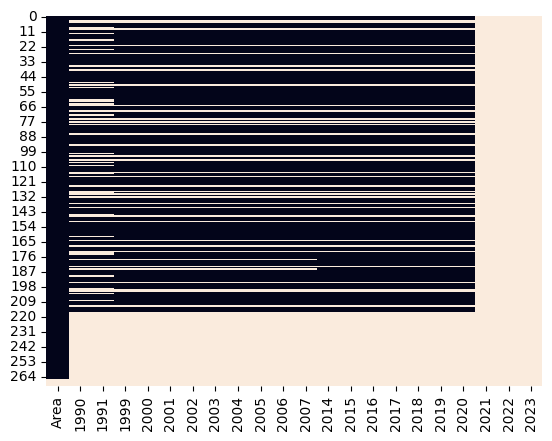

In [23]:
sns.heatmap(prec.isnull(), cbar=False) # Visualize null values with a heatmap

In [24]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area      1.845018
1990     42.066421
1991     42.066421
1999     33.579336
2000     33.579336
2001     33.579336
2002     33.579336
2003     33.579336
2004     33.579336
2005     33.579336
2006     33.579336
2007     33.579336
2014     32.841328
2015     32.841328
2016     32.841328
2017     32.841328
2018     32.841328
2019     32.841328
2020     32.841328
2021    100.000000
2022    100.000000
2023    100.000000
dtype: float64

In [25]:
# percentage of nan values (rows)
prec.isnull().sum(axis=1) / prec.shape[1] * 100

0       13.636364
1       13.636364
2       13.636364
3       95.454545
4       95.454545
          ...    
266    100.000000
267    100.000000
268    100.000000
269    100.000000
270    100.000000
Length: 271, dtype: float64

In [26]:
# # Calculate the percentage of null values in each row
percent_missing_rows = prec.isnull().sum(axis=1) / prec.shape[1] * 100

# Filter out rows with a percentage of nulls = 100
missing_rows = percent_missing_rows[percent_missing_rows==100].index

# Display rows with a percentage of nulls = 100
prec.loc[missing_rows]

# delete missing_rows
prec.drop(missing_rows, inplace=True)

In [27]:
# no information of the columns 2021, 2022, 2023. Delete

prec.drop(columns=['2021', '2022','2023'], inplace=True)

In [28]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area     0.000000
1990    40.977444
1991    40.977444
1999    32.330827
2000    32.330827
2001    32.330827
2002    32.330827
2003    32.330827
2004    32.330827
2005    32.330827
2006    32.330827
2007    32.330827
2014    31.578947
2015    31.578947
2016    31.578947
2017    31.578947
2018    31.578947
2019    31.578947
2020    31.578947
dtype: float64

In [29]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    266 non-null    object
 1   1990    157 non-null    object
 2   1991    157 non-null    object
 3   1999    180 non-null    object
 4   2000    180 non-null    object
 5   2001    180 non-null    object
 6   2002    180 non-null    object
 7   2003    180 non-null    object
 8   2004    180 non-null    object
 9   2005    180 non-null    object
 10  2006    180 non-null    object
 11  2007    180 non-null    object
 12  2014    182 non-null    object
 13  2015    182 non-null    object
 14  2016    182 non-null    object
 15  2017    182 non-null    object
 16  2018    182 non-null    object
 17  2019    182 non-null    object
 18  2020    182 non-null    object
dtypes: object(19)
memory usage: 39.6+ KB


In [30]:
prec.columns

Index(['Area', '1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

In [31]:
# Change the number columns type to float
year_col = ['1990', '1991', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020']
prec[year_col]= prec[year_col].astype(float)

As the rainfall values are mm per year and they are continuous variables, we will do the imputation with the mean value of mm per year:

In [32]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in prec.columns:
    repair_null(prec, col)

prec.isnull().sum()/len(prec)*100

Area    0.0
1990    0.0
1991    0.0
1999    0.0
2000    0.0
2001    0.0
2002    0.0
2003    0.0
2004    0.0
2005    0.0
2006    0.0
2007    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
2019    0.0
2020    0.0
dtype: float64

In [33]:
# calculation of the average rain fall from 1990-present in a new column

prec['avg_rainfall_mm_year'] = prec[year_col].mean(axis=1).round(2)

In [69]:
# create a new df with Area and average columns
prec_filtered = prec[['Area','avg_rainfall_mm_year']].copy()
prec_filtered

,Area,average_1990_2020
0,Afghanistan,327.00
1,Albania,1485.00
2,Algeria,89.00
3,American Samoa,1183.25
4,Andorra,1183.25
...,...,...
261,Sub-Saharan Africa,1183.25
262,Sub-Saharan Africa (excluding high income),1183.25
263,Sub-Saharan Africa (IDA & IBRD countries),1183.25
264,Upper middle income,1183.25


### 2.3. <a id='toc2_3_'></a>[Pesticides dataset](#toc2_3_)

In [68]:
pest = pd.read_csv('Data/pesticides_use/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv',encoding='latin-1',low_memory=False)

In [69]:
# To have the same years in the datasets, filter the datasets from year 1990
pest = pest[pest['Year']>=1990]

In [70]:
pest.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1990,1990,t,121.0,E,NaN
1,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1991,1991,t,121.0,E,NaN
2,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1992,1992,t,121.0,E,NaN
3,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1993,1993,t,121.0,E,NaN
4,3,'008,Albania,1357,Pesticides (total),5157,Agricultural Use,1994,1994,t,201.0,E,NaN


In [71]:
pest['Element'].unique()

array(['Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [72]:
# delete element types
delete_elements = ['Use per capita','Use per area of cropland','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
pest = pest[~pest['Element'].isin(delete_elements)]

In [75]:
# create new filtered df
pest_filtered = pest[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
pest_filtered.rename(columns={'Item': 'pesticides_type'}, inplace=True)
pest_filtered.rename(columns={'Value': 'agricultural use_tonnes'}, inplace=True)
# Delete Element column
pest_filtered.drop(columns=['Element'], inplace=True)

In [76]:
pest_filtered.head()

,Area,pesticides_type,Year,agricultural use_tonnes
0,Albania,Pesticides (total),1990,121.0
1,Albania,Pesticides (total),1991,121.0
2,Albania,Pesticides (total),1992,121.0
3,Albania,Pesticides (total),1993,121.0
4,Albania,Pesticides (total),1994,201.0


### 2.4. <a id='toc2_4_'></a>[Fertilizers dataset](#toc2_4_)

In [78]:
fert = pd.read_csv('Data/fertilizers/Inputs_FertilizersNutrient_E_All_Data_Normalized.csv',encoding='latin-1',low_memory=False)

In [79]:
# To have the same years in the datasets, filter the datasets from year 1990
fert_filtered = fert[fert['Year']>=1990]

In [67]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1974,1974,t,19117.0,A,Official data from questionnaire
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1975,1975,t,14774.0,A,Official data from questionnaire
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1976,1976,t,26203.0,A,Official data from questionnaire
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1977,1977,t,37689.0,A,Official data from questionnaire
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,1978,1978,t,48300.0,A,Official data from questionnaire


In [71]:
fert['Element'].unique()

array(['Production', 'Import Quantity', 'Export Quantity',
       'Agricultural Use', 'Use per area of cropland', 'Use per capita',
       'Use per value of agricultural production'], dtype=object)

In [80]:
# delete element types
delete_elements = ['Import Quantity', 'Export Quantity', 'Use per capita','Use per value of agricultural production']

# Filter the DataFrame to exclude the rows with the specified elements, and keep production, agricultural use and Use per area of cropland
fert = fert[~fert['Element'].isin(delete_elements)]
# Change the name to Elements type
fert['Element'] = fert['Element'].replace('Production', 'production_tonnes')
fert['Element'] = fert['Element'].replace('Agricultural Use', 'agricultural use_tonnes')
fert['Element'] = fert['Element'].replace('Use per area of cropland', 'use per area_kg/ha')

In [77]:
fert.head()

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Flag_description
0,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1974,1974,t,19117.0,A,Official data from questionnaire,Official figure
1,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1975,1975,t,14774.0,A,Official data from questionnaire,Official figure
2,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1976,1976,t,26203.0,A,Official data from questionnaire,Official figure
3,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1977,1977,t,37689.0,A,Official data from questionnaire,Official figure
4,2,'004,Afghanistan,3102,Nutrient nitrogen N (total),5510,production_tonnes,1978,1978,t,48300.0,A,Official data from questionnaire,Official figure


In [81]:
# create new filtered df
fert_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
fert_filtered.rename(columns={'Item': 'fertilizer_type'}, inplace=True)

### 2.5. <a id='toc2_5_'></a>[Temperature dataset](#toc2_5_)

In [14]:
# Data: https://tradingeconomics.com/country-list/temperature
temp = {
    'Country': [
        'Burkina Faso', 'Mali', 'Qatar', 'Senegal', 'United Arab Emirates', 'Mauritania', 'Bahrain',
        'Aruba', 'Djibouti', 'Gambia', 'Benin', 'Maldives', 'Guinea Bissau', 'Cayman Islands',
        'Oman', 'Marshall Islands', 'Kiribati', 'Ghana', 'Singapore', 'Niger', 'Kuwait', 'Sudan',
        'Guam', 'Palau', 'Samoa', 'Togo', 'Micronesia', 'St Kitts and Nevis', 'American Samoa',
        'Chad', 'Cambodia', 'Northern Mariana Islands', 'Sri Lanka', 'Nigeria', 'Seychelles',
        'Somalia', 'Antigua and Barbuda', 'Ivory Coast', 'Virgin Islands', 'St Lucia', 'Thailand',
        'Dominica', 'Sierra Leone', 'Philippines', 'Suriname', 'Eritrea', 'Saudi Arabia',
        'Trinidad and Tobago', 'Barbados', 'Malaysia', 'Grenada', 'Guyana', 'Cuba', 'Bahamas',
        'Jamaica', 'St Vincent and the Grenadines', 'Indonesia', 'Guinea', 'Solomon Islands',
        'Belize', 'Nicaragua', 'Bangladesh', 'Central African Republic', 'Brazil', 'Venezuela',
        'Yemen', 'Liberia', 'Gabon', 'Panama', 'El Salvador', 'Kenya', 'India', 'Tonga',
        'Republic of the Congo', 'Haiti', 'Fiji', 'Cameroon', 'Puerto Rico', 'Equatorial Guinea',
        'Mayotte', 'Papua New Guinea', 'Vanuatu', 'Vietnam', 'Colombia', 'Honduras',
        'Sao Tome and Principe', 'Costa Rica', 'Dominican Republic', 'Mozambique', 'Congo',
        'Algeria', 'French Polynesia', 'Laos', 'Myanmar', 'Paraguay', 'Iraq', 'Guatemala',
        'Comoros', 'Hong Kong', 'Ethiopia', 'Macau', 'New Caledonia', 'Mauritius', 'Egypt',
        'Uganda', 'Tanzania', 'Libya', 'Madagascar', 'Cape Verde', 'Malawi', 'Pakistan',
        'Botswana', 'Australia', 'Zambia', 'Zimbabwe', 'Mexico', 'Angola', 'Tunisia', 'Ecuador',
        'Swaziland', 'Taiwan', 'Bolivia', 'Burundi', 'Malta', 'Namibia', 'Israel', 'Jordan',
        'Palestine', 'Peru', 'Cyprus', 'Iran', 'Syria', 'Rwanda', 'Morocco', 'South Africa',
        'Uruguay', 'Turkmenistan', 'Portugal', 'Lebanon', 'Spain', 'Argentina', 'Monaco',
        'Greece', 'Uzbekistan', 'Afghanistan', 'Nepal', 'Italy', 'San Marino', 'Azerbaijan',
        'Albania', 'Croatia', 'France', 'South Korea', 'Lesotho', 'Hungary', 'Serbia', 'Japan',
        'Bulgaria', 'Turkey', 'Belgium', 'Moldova', 'Netherlands', 'Macedonia', 'New Zealand',
        'Bosnia and Herzegovina', 'Luxembourg', 'Romania', 'Slovenia', 'Montenegro', 'Germany',
        'Bhutan', 'Ireland', 'United Kingdom', 'Ukraine', 'Georgia', 'Isle of Man', 'Slovakia',
        'Denmark', 'Andorra', 'United States', 'Czech Republic', 'Poland', 'Chile', 'Liechtenstein',
        'Austria', 'Armenia', 'China', 'Switzerland', 'Kazakhstan', 'Belarus', 'Lithuania',
        'North Korea', 'Latvia', 'Faroe Islands', 'Estonia', 'Tajikistan', 'Kyrgyzstan', 'Sweden',
        'Finland', 'Norway', 'Iceland', 'Mongolia', 'Russia', 'Canada', 'Greenland'
    ],
    'Last': [
    29.28, 29.19, 29.11, 29.00, 28.93, 28.9, 28.84, 28.82, 28.6, 28.46, 28.09, 28.08, 28.05, 28.01,
    27.94, 27.9, 27.77, 27.73, 27.7, 27.61, 27.58, 27.57, 27.54, 27.54, 27.53, 27.47, 27.45, 27.34,
    27.31, 27.28, 27.25, 27.25, 27.24, 27.15, 27.11, 27.1, 27.06, 26.84, 26.84, 26.83, 26.78, 26.68,
    26.64, 26.61, 26.53, 26.49, 26.46, 26.46, 26.45, 26.35, 26.33, 26.16, 26.14, 26.05, 26.02, 25.98,
    25.96, 25.95, 25.89, 25.83, 25.81, 25.74, 25.56, 25.54, 25.52, 25.51, 25.47, 25.46, 25.33, 25.23,
    25.22, 25.2, 25.1, 25.05, 25.01, 24.98, 24.94, 24.94, 24.89, 24.87, 24.78, 24.76, 24.73, 24.71,
    24.71, 24.66, 24.64, 24.57, 24.42, 24.38, 24.11, 24.05, 24.05, 23.96, 23.86, 23.81, 23.77, 23.74,
    23.62, 23.45, 23.4, 23.37, 23.27, 23.23, 23.14, 22.9, 22.8, 22.7, 22.67, 22.55, 22.23, 22.00,
    21.96, 21.92, 21.83, 21.7, 21.63, 21.44, 21.07, 20.92, 20.79, 20.68, 20.43, 20.26, 20.24, 20.23,
    19.77, 19.7, 19.58, 19.33, 19.3, 19.17, 19.14, 19.1, 18.42, 17.73, 17.66, 16.9, 15.66, 15.3, 15.07,
    15.01, 14.88, 14.86, 14.48, 14.39, 14.38, 14.14, 13.84, 13.31, 13.16, 13.16, 12.76, 12.64, 12.62,
    12.56, 12.42, 12.28, 12.24, 11.98, 11.9, 11.72, 11.66, 11.66, 11.57, 11.43, 11.2, 11.04, 11.00,
    10.83, 10.56, 10.35, 10.11, 10.04, 9.92, 9.89, 9.81, 9.77, 9.73, 9.73, 9.71, 9.7, 9.37, 9.05,
    8.65, 8.64, 8.1, 8.08, 8.06, 7.98, 7.95, 7.46, 7.4, 7.1, 6.9, 5.09, 3.93, 3.84, 3.24, 2.88,
    2.11, 1.31, -2.87, -4.22, -18.62
],
    'Previous': [
    30.01, 29.78, 29.42, 29.62, 29.09, 29.3, 29.18, 29.03, 28.52, 29.03, 28.7, 28.14, 28.68, 27.99,
    28.1, 28.16, 27.89, 28.3, 27.75, 28.09, 27.89, 28.17, 27.88, 27.58, 27.54, 28.04, 27.42, 27.6,
    27.34, 27.7, 27.44, 27.65, 27.4, 27.67, 27.26, 26.93, 27.33, 27.37, 27.11, 27.03, 26.9, 26.9,
    27.19, 26.7, 26.56, 26.88, 26.8, 26.58, 26.63, 26.47, 26.49, 26.15, 26.06, 25.87, 26.07, 26.16,
    26.01, 26.6, 25.89, 26.15, 26.09, 25.7, 25.78, 25.57, 25.61, 25.64, 25.87, 25.66, 25.59, 25.53,
    25.25, 25.09, 25.16, 25.23, 25.15, 25.03, 25.2, 25.17, 25.08, 25.08, 24.79, 24.66, 25.04, 24.97,
    25.03, 24.93, 24.89, 24.75, 24.53, 24.46, 23.92, 24.45, 24.34, 24.11, 24.01, 24.21, 24.08, 23.92,
    24.19, 23.41, 23.96, 23.09, 23.7, 23.88, 23.22, 23.0, 23.05, 22.87, 22.76, 22.8, 22.03, 21.74,
    22.05, 22.11, 21.87, 21.85, 21.74, 21.33, 21.42, 20.52, 21.07, 20.8, 20.51, 20.22, 20.12, 20.86,
    20.36, 20.34, 19.79, 19.87, 19.57, 19.67, 19.21, 18.48, 18.06, 18.06, 17.69, 16.1, 16.2, 14.31,
    15.4, 13.62, 15.09, 14.76, 14.28, 14.29, 13.52, 13.16, 13.9, 12.89, 12.19, 11.58, 13.14, 12.28,
    11.58, 11.7, 12.45, 11.97, 12.61, 10.48, 10.95, 10.41, 11.39, 11.18, 10.7, 9.77, 10.35, 10.0,
    10.25, 9.49, 10.73, 9.94, 9.39, 9.37, 10.05, 9.92, 8.79, 8.96, 8.38, 10.01, 8.5, 8.75, 9.81,
    7.44, 7.41, 8.81, 8.21, 6.39, 7.83, 7.33, 7.28, 7.81, 6.82, 6.7, 6.3, 4.61, 3.36, 3.08, 2.34,
    2.11, 2.43, 2.08, -3.65, -3.7, -17.6
]
}

temp = pd.DataFrame(temp)
temp


,Country,Last,Previous
0,Burkina Faso,29.28,30.01
1,Mali,29.19,29.78
2,Qatar,29.11,29.42
3,Senegal,29.00,29.62
4,United Arab Emirates,28.93,29.09
...,...,...,...
200,Iceland,2.11,2.43
201,Mongolia,1.31,2.08
202,Russia,-2.87,-3.65
203,Canada,-4.22,-3.70


In [15]:
# calculation of the average temperature last & previous in a new column

temp['avg_temp_ºC'] = temp[['Last','Previous']].mean(axis=1).round(2)

# drop Last & previous columns
temp = temp.drop(['Last','Previous'], axis=1)
# Change the name to the new column
temp.rename(columns={'Country': 'Area'}, inplace=True)

In [16]:
temp.head()

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48
2,Qatar,29.26
3,Senegal,29.31
4,United Arab Emirates,29.01


## 3. <a id='toc3_'></a>[Create final dataframe](#toc3_)

Merge crop & prec_filtered & temp

In [55]:
crop.shape

(893871, 7)

In [56]:
crop['Area'].nunique()

245

In [72]:
crop.head(2)

,Area,Item Code,Item,Element,Year,Value,Flag,Flag_description
0,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1991,5500.0,A,Official figure
1,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1992,5500.0,A,Official figure


In [57]:
prec_filtered.shape

NameError: name 'prec_filtered' is not defined

In [74]:
prec_filtered['Area'].nunique()

266

In [75]:
prec_filtered.head(2)

,Area,average_1990_2020
0,Afghanistan,327.0
1,Albania,1485.0


In [76]:
temp['Area'].nunique()

205

In [77]:
temp.head(2)

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48


There are more countries in the df prec_filtered. Let's merge them and use an inner join so that only rows that have matches in both tables are included in the column you use to join. Rows that do not have matches in both tables will not be included in the resulting DataFrame.

In [78]:
df = crop.merge(prec_filtered, on='Area', how='inner')
df = df.merge(temp, on='Area', how='inner')

In [53]:
df['Area'].nunique()

168

In [79]:
df.head()

,Area,Item Code,Item,Element,Year,Value,Flag,Flag_description,average_1990_2020,avg_temp_ºC
0,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1991,5500.0,A,Official figure,327.0,14.38
1,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1992,5500.0,A,Official figure,327.0,14.38
2,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1993,5500.0,A,Official figure,327.0,14.38
3,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1994,5500.0,A,Official figure,327.0,14.38
4,Afghanistan,221,"Almonds, in shell",area_harvested_ha,1995,5500.0,A,Official figure,327.0,14.38


# EDA

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122102 entries, 0 to 1122101
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Area               1122102 non-null  object 
 1   Item Code          1122102 non-null  int64  
 2   Item               1122102 non-null  object 
 3   Element            1122102 non-null  object 
 4   Year               1122102 non-null  int64  
 5   Value              1122102 non-null  float64
 6   Flag               1122102 non-null  object 
 7   Flag_description   1122102 non-null  object 
 8   average_1990_2020  1122102 non-null  float64
 9   avg_temp_ºC        1122102 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 85.6+ MB


In [82]:
df['Item Code'] = df['Item Code'].astype('object')

In [ ]:
# Set the display of numbers in decimal notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Year,1122102.0,2006.324203,9.409940e+00,1990.00,1998.0000,2006.00,2014.00,2.022000e+03
Value,1122102.0,521139.355742,7.711766e+06,0.00,1287.1125,13874.00,87986.25,7.685942e+08
average_1990_2020,1122102.0,1162.846969,7.738142e+02,56.00,600.0000,1030.00,1668.00,3.205110e+03
avg_temp_ºC,1122102.0,19.350827,7.543682e+00,-3.96,12.4300,21.85,25.67,2.965000e+01


C:\Users\kina5\AppData\Local\Temp\ipykernel_19800\469947334.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(var1, kde=True, ax=axes[0], color=color_palette[1], fit=stats.norm)
C:\Users\kina5\AppData\Local\Temp\ipykernel_19800\469947334.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(va

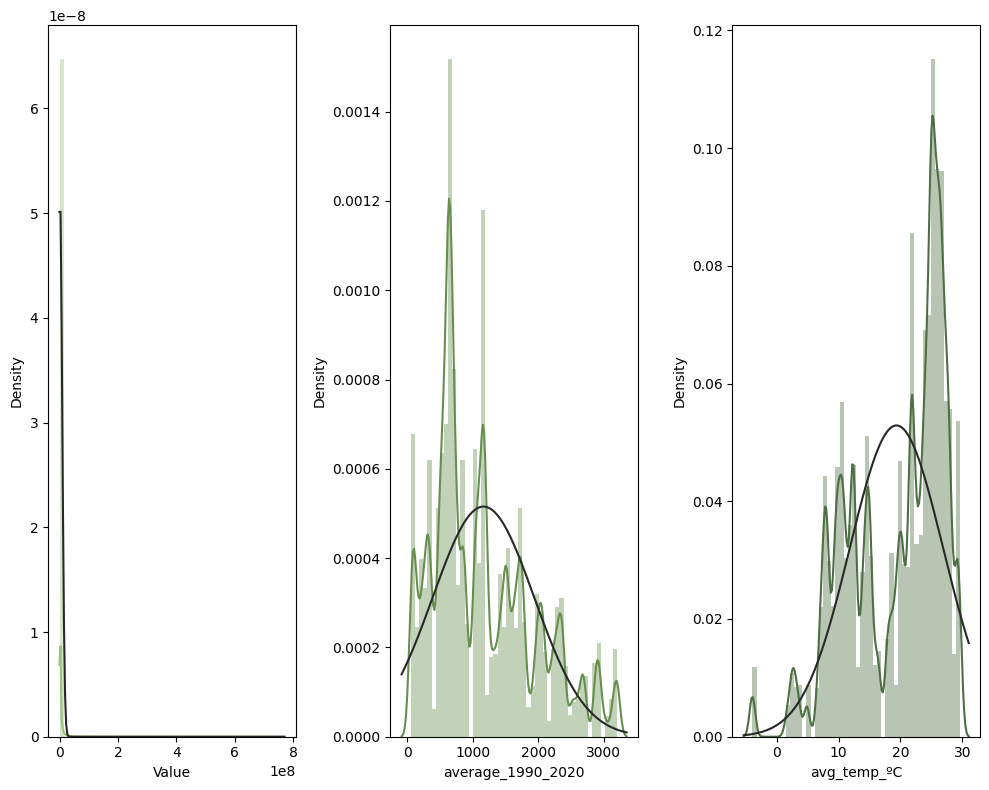

In [91]:
# Visualisation of continuous variables
from scipy import stats

var1 = df['Value']
var2 = df['average_1990_2020']
var3 = df['avg_temp_ºC']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

# Plot distplot for each subplot
(mu, sigma) = stats.norm.fit(var1)
sns.distplot(var1, kde=True, ax=axes[0], color=color_palette[1], fit=stats.norm)

(mu, sigma) = stats.norm.fit(var2)
sns.distplot(var2, kde=True, ax=axes[1], color=color_palette[3], fit=stats.norm)

(mu, sigma) = stats.norm.fit(var3)
sns.distplot(var3, kde=True, ax=axes[2], color=color_palette[4], fit=stats.norm)

# Adjust the design
plt.tight_layout()

# Show
plt.show()